In [106]:
import pandas as pd

df = pd.read_csv("../data/analysis/embedding_eval_results.csv")
df = df[(df['golden_ids'] != "[]")]
# df.head().to_markdown(index=False)
# df

In [107]:
invalid_ids = ['001-104858', '001-112101', '001-120965', '001-121325', '001-122365', '001-139608', '001-140594', '001-142529', '001-148286', '001-159768', '001-160692', '001-161986', '001-164462', '001-165262', '001-169737', '001-169844', '001-173623', '001-175572', '001-180084', '001-183961', '001-186667', '001-193035', '001-194051', '001-199300', '001-199494', '001-202347', '001-206079', '001-209029', '001-209496', '001-212877', '001-213519', '001-213717', '001-214312', '001-215358', '001-216158', '001-218074', '001-218920', '001-219642', '001-220532', '001-220954', '001-222651', '001-222790', '001-222867', '001-223365', '001-224778', '001-225763', '001-226011', '001-226432', '001-226449', '001-226466', '001-228837', '001-229395', '001-229933', '001-230633', '001-231341', '001-57479', '001-58126', '001-58912', '001-59470', '001-60413', '001-61121', '001-69564', '001-75548', '001-81008', '003-7317048-10811277']

In [108]:
# Drop rows where golden_ids were possibly not retrievable
import ast
def contains_invalid(golden_ids, invalid_ids):
    if not isinstance(golden_ids, list):
        golden_ids = ast.literal_eval(golden_ids)
    return any(gid in invalid_ids for gid in golden_ids)

df = df[~df['golden_ids'].apply(lambda x: contains_invalid(x, invalid_ids))]
df.reset_index(drop=True, inplace=True)
# df

In [109]:
def strip_ron_prefix_suffix(val):
    if isinstance(val, str) and val.endswith('_ron') and (val.startswith('ron_') or val.startswith('translation_ron_')):
        return val[:-len('_ron')]
    return val

df['doc_db'] = df['doc_db'].apply(strip_ron_prefix_suffix)
df['query_embedding'] = df['query_embedding'].apply(strip_ron_prefix_suffix)

In [110]:
print("Unique values in 'doc_db':", df['doc_db'].unique())
print("Unique values in 'query_embedding':", df['query_embedding'].unique())

Unique values in 'doc_db': ['echr_topic_ron' 'ron_echr_topic' 'no_instruct' 'echr_topic']
Unique values in 'query_embedding': ['base_ron' 'translation_base_ron' 'ron_echr_retrieve' 'echr_retrieve'
 'translation_ron_echr_retrieve' 'LegalBenchCorporateLobbying_ron'
 'translation_echr_retrieve' 'LegalBenchCorporateLobbying'
 'translation_ron_base' 'translation_echr_retrieve_ron'
 'translation_LegalBenchCorporateLobbying' 'echr_retrieve_ron' 'ron_base'
 'no_instruct' 'translation_base' 'translation_no_instruct' 'base'
 'translation_LegalBenchCorporateLobbying_ron']


In [111]:
# Compute recall@10 from retrieved_ids and golden_ids
import numpy as np
import ast

def recall_at_k(retrieved, golden, k=10):
    if not isinstance(retrieved, list):
        retrieved = ast.literal_eval(retrieved)
    if not isinstance(golden, list):
        golden = ast.literal_eval(golden)
    if not golden:
        return np.nan
    retrieved_k = set(retrieved[:k])
    golden_set = set(golden)
    return len(retrieved_k & golden_set) / len(golden_set)

df['recall@10'] = df.apply(lambda row: recall_at_k(row['retrieved_ids@10'], row['golden_ids'], k=10), axis=1)
df.head().to_markdown(index=False)
# df

"| question_id                | doc_db         | query_embedding   | golden_ids                                                             |   precision@10 |   recall@10 |    f1@10 |   mrr@10 |   ndcg@10 | retrieved_ids@10                                                                                                                            |   precision@20 |   recall@20 |     f1@20 |   mrr@20 |   ndcg@20 | retrieved_ids@20                                                                                                                                                                                                                                                                        |\n|:---------------------------|:---------------|:------------------|:-----------------------------------------------------------------------|---------------:|------------:|---------:|---------:|----------:|:------------------------------------------------------------------------------------------------

In [112]:


baseline_doc_db = 'no_instruct'
baseline_query = 'base'


In [113]:
print(f"Comparing to baseline: doc_db='{baseline_doc_db}', query_embedding='{baseline_query}'")


from scipy.stats import ttest_rel
baseline_scores = df[(df['doc_db'] == baseline_doc_db) & (df['query_embedding'] == baseline_query)]['recall@10']
results = []

for name, group in df.groupby(['doc_db', 'query_embedding']):
    doc_db, query_embedding = name
    if doc_db == baseline_doc_db and query_embedding == baseline_query:
        continue
    
    group_scores = group['recall@10']
    
    if len(group_scores) != len(baseline_scores):
        raise ValueError(f"Group {name} has a different number of scores than the baseline.")
    
    stat, p_value = ttest_rel(baseline_scores, group_scores)
    
    results.append({
        'doc_db': doc_db,
        'query_embedding': query_embedding,
        'mean_recall@10': group_scores.mean(),
        'baseline_mean_recall@10': baseline_scores.mean(),
        'p_value': p_value,
        'stat': stat,
    })

results_df = pd.DataFrame(results)

results_df = results_df[~results_df['query_embedding'].str.contains('translation')]
print("Only keeping non-translated query embeddings.")

results_df.sort_values(by='stat', inplace=True, ascending=True)
print(results_df.head().to_markdown(index=False))
# results_df

Comparing to baseline: doc_db='no_instruct', query_embedding='base'
Only keeping non-translated query embeddings.
| doc_db         | query_embedding   |   mean_recall@10 |   baseline_mean_recall@10 |     p_value |     stat |
|:---------------|:------------------|-----------------:|--------------------------:|------------:|---------:|
| echr_topic     | echr_retrieve     |         0.298256 |                  0.264238 | 0.000491461 | -3.51088 |
| echr_topic     | base              |         0.294116 |                  0.264238 | 0.00138973  | -3.21673 |
| echr_topic_ron | echr_retrieve_ron |         0.292543 |                  0.264238 | 0.00534823  | -2.79883 |
| echr_topic_ron | echr_retrieve     |         0.291748 |                  0.264238 | 0.0072615   | -2.69685 |
| echr_topic     | ron_base          |         0.287544 |                  0.264238 | 0.00807409  | -2.66075 |


In [150]:
# Wilcoxon signed-rank tests vs baseline only, with Benjamini–Hochberg correction
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

bw_df = df[~df['query_embedding'].str.contains('translation')].copy()

# Preconditions
if 'bw_df' not in globals():
    raise RuntimeError("DataFrame 'bw_df' not found. Run the data loading cell first or ensure bw_df is defined.")
if 'recall@10' not in bw_df.columns:
    raise RuntimeError("Column 'recall@10' not found. Compute it before running this cell.")
if 'baseline_doc_db' not in globals() or 'baseline_query' not in globals():
    raise RuntimeError("Baseline variables not set. Define 'baseline_doc_db' and 'baseline_query' first.")

# Baseline subset (question_id alignment)
base_mask = (bw_df['doc_db'] == baseline_doc_db) & (bw_df['query_embedding'] == baseline_query)
base_subset = bw_df.loc[base_mask, ['question_id', 'recall@10']].rename(columns={'recall@10': 'recall_baseline'})
if base_subset.empty:
    raise ValueError(f"No baseline rows for doc_db='{baseline_doc_db}', query_embedding='{baseline_query}'.")

baseline_mean = float(base_subset['recall_baseline'].mean())

wilcoxon_rows = []
for (doc_db, query_embedding), group in bw_df.groupby(['doc_db', 'query_embedding']):
    # Skip baseline itself
    if doc_db == baseline_doc_db and query_embedding == baseline_query:
        continue

    grp = group[['question_id', 'recall@10']].rename(columns={'recall@10': 'recall_group'})
    merged = base_subset.merge(grp, on='question_id', how='inner').dropna()

    # Need enough paired samples; also Wilcoxon requires some non-zero differences
    if len(merged) < 5:
        continue

    try:
        # Baseline first, group second (keeps sign consistent with earlier cells)
        stat, p_value = wilcoxon(merged['recall_baseline'], merged['recall_group'], alternative='two-sided')
        diffs = merged['recall_group'].to_numpy() - merged['recall_baseline'].to_numpy()
        n_pairs = int(len(merged))
        n_non_zero = int(np.sum(diffs != 0))
        n_ties = int(n_pairs - n_non_zero)
        ties_pct = float(n_ties / n_pairs) if n_pairs > 0 else float('nan')
        if n_non_zero > 0:
            # Approximate Z-score for effect size r
            z_score = (stat - n_non_zero * (n_non_zero + 1) / 4) / np.sqrt(n_non_zero * (n_non_zero + 1) * (2 * n_non_zero + 1) / 24)
            effect_size_r = z_score / np.sqrt(n_non_zero)
        else:
            effect_size_r = 0.0

        wilcoxon_rows.append({
            'doc_db': doc_db,
            'query_embedding': query_embedding,
            'mean_recall@10': float(grp['recall_group'].mean()),
            'baseline_mean_recall@10': baseline_mean,
            'median_recall@10': float(grp['recall_group'].median()),
            'n_pairs': n_pairs,
            'n_ties': n_ties,
            'ties_pct': ties_pct,
            'wilcoxon_stat': float(stat),
            'p_value': float(p_value),
            'effect_size_r': float(effect_size_r),
            'mean_diff': float(merged['recall_group'].mean() - merged['recall_baseline'].mean())
        })
    except Exception:
        # Skip comparisons where Wilcoxon cannot be computed (e.g., all diffs zero)
        continue

wilcoxon_baseline_df = pd.DataFrame(wilcoxon_rows)

if not wilcoxon_baseline_df.empty:
    rejected, p_adj, _, _ = multipletests(wilcoxon_baseline_df['p_value'].values, method='fdr_bh', alpha=0.05)
    wilcoxon_baseline_df['p_adjusted_bh'] = p_adj
    wilcoxon_baseline_df['significant_bh'] = rejected
    wilcoxon_baseline_df = wilcoxon_baseline_df.sort_values('p_value', ascending=True)

    print(f"Total comparisons vs baseline: {len(wilcoxon_baseline_df)}")
    print(f"Significant after BH correction (α=0.05): {int(wilcoxon_baseline_df['significant_bh'].sum())}")
    print(f"Mean raw p-value: {wilcoxon_baseline_df['p_value'].mean():.4f}")
    print(f"Median raw p-value: {wilcoxon_baseline_df['p_value'].median():.4f}")

    display_cols = ['doc_db', 'query_embedding', 'mean_diff', 'p_value', 'p_adjusted_bh', 'significant_bh', 'effect_size_r', 'n_pairs', 'n_ties', 'ties_pct', 'mean_recall@10', 'baseline_mean_recall@10']
    print("\nTop 20 most significant vs baseline (by p-value):")
    print(wilcoxon_baseline_df[display_cols].head(20).to_markdown(index=False))
else:
    print("No valid Wilcoxon comparisons vs baseline could be performed.")

# Expose also a non-translation filtered view for convenience (optional)
wilcoxon_baseline_no_trans_df = (
    wilcoxon_baseline_df[~wilcoxon_baseline_df['query_embedding'].str.contains('translation')]
    if not wilcoxon_baseline_df.empty else wilcoxon_baseline_df
)
wilcoxon_baseline_no_trans_df

Total comparisons vs baseline: 35
Significant after BH correction (α=0.05): 8
Mean raw p-value: 0.2108
Median raw p-value: 0.0778

Top 20 most significant vs baseline (by p-value):
| doc_db         | query_embedding                 |   mean_diff |     p_value |   p_adjusted_bh | significant_bh   |   effect_size_r |   n_pairs |   n_ties |   ties_pct |   mean_recall@10 |   baseline_mean_recall@10 |
|:---------------|:--------------------------------|------------:|------------:|----------------:|:-----------------|----------------:|----------:|---------:|-----------:|-----------------:|--------------------------:|
| echr_topic     | echr_retrieve                   |  0.0340185  | 0.000677958 |      0.00851609 | True             |       -0.247715 |       453 |      265 |   0.584989 |         0.298256 |                  0.264238 |
| echr_topic     | base                            |  0.0298785  | 0.00071483  |      0.00851609 | True             |       -0.262494 |       453 |      287 |   0

,doc_db,query_embedding,mean_recall@10,baseline_mean_recall@10,median_recall@10,n_pairs,n_ties,ties_pct,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
4,echr_topic,echr_retrieve,0.298256,0.264238,0.222222,453,265,0.584989,6345.5,0.000678,-0.247715,0.034019,0.008516,True
2,echr_topic,base,0.294116,0.264238,0.222222,453,287,0.633554,4833.0,0.000715,-0.262494,0.029879,0.008516,True
14,echr_topic_ron,echr_retrieve_ron,0.292543,0.264238,0.230769,453,258,0.569536,6891.5,0.000730,-0.241717,0.028305,0.008516,True
7,echr_topic,ron_base,0.287544,0.264238,0.200000,453,277,0.611479,5774.5,0.002917,-0.224218,0.023306,0.025187,True
13,echr_topic_ron,echr_retrieve,0.291748,0.264238,0.222222,453,258,0.569536,7259.0,0.003598,-0.208366,0.027510,0.025187,True
9,echr_topic_ron,LegalBenchCorporateLobbying,0.286388,0.264238,0.214286,453,276,0.609272,5973.0,0.005272,-0.209585,0.022150,0.030754,True
10,echr_topic_ron,LegalBenchCorporateLobbying_ron,0.285717,0.264238,0.200000,453,275,0.607064,6135.0,0.007798,-0.199294,0.021479,0.038992,True
31,ron_echr_topic,echr_retrieve_ron,0.287098,0.264238,0.222222,453,262,0.578366,7232.0,0.011320,-0.183117,0.022860,0.049526,True
26,ron_echr_topic,LegalBenchCorporateLobbying,0.284926,0.264238,0.222222,453,275,0.607064,6272.0,0.013850,-0.184378,0.020689,0.053860,False
33,ron_echr_topic,ron_base,0.285442,0.264238,0.200000,453,274,0.604857,6397.0,0.016860,-0.178506,0.021204,0.057529,False


In [119]:
# Wilcoxon signed-rank test with Benjamini-Hochberg correction for all pairwise comparisons
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from itertools import combinations

w_df = df[~df['query_embedding'].str.contains('translation')].copy()

# Create all unique (doc_db, query_embedding) combinations
unique_configs = w_df[['doc_db', 'query_embedding']].drop_duplicates()
config_list = [(row['doc_db'], row['query_embedding']) for _, row in unique_configs.iterrows()]

# Generate all pairwise combinations
pairwise_comparisons = list(combinations(config_list, 2))

# Run Wilcoxon signed-rank test for each pair
wilcoxon_results = []

for (doc_db1, query_emb1), (doc_db2, query_emb2) in pairwise_comparisons:
    # Get scores for configuration 1
    config1_scores = w_df[(w_df['doc_db'] == doc_db1) & (w_df['query_embedding'] == query_emb1)].set_index('question_id')['recall@10']

    # Get scores for configuration 2
    config2_scores = w_df[(w_df['doc_db'] == doc_db2) & (w_df['query_embedding'] == query_emb2)].set_index('question_id')['recall@10']

    # Find common question_ids
    common_ids = config1_scores.index.intersection(config2_scores.index)
    
    if len(common_ids) < 5:  # Skip if too few paired samples
        continue
    
    # Get paired scores
    scores1_paired = config1_scores.loc[common_ids].values
    scores2_paired = config2_scores.loc[common_ids].values
    
    # Perform Wilcoxon signed-rank test
    try:
        stat, p_value = wilcoxon(scores1_paired, scores2_paired, alternative='two-sided')
        
        # Calculate effect size (r = Z / sqrt(N))
        differences = scores2_paired - scores1_paired
        n_non_zero = np.sum(differences != 0)
        if n_non_zero > 0:
            # Approximate Z-score from Wilcoxon statistic
            z_score = (stat - n_non_zero * (n_non_zero + 1) / 4) / np.sqrt(n_non_zero * (n_non_zero + 1) * (2 * n_non_zero + 1) / 24)
            effect_size_r = z_score / np.sqrt(n_non_zero)
        else:
            effect_size_r = 0
        
        wilcoxon_results.append({
            'A_doc_db': doc_db1,
            'A_query_embedding': query_emb1,
            'B_doc_db': doc_db2,
            'B_query_embedding': query_emb2,
            'mean_recall@10_A': scores1_paired.mean(),
            'mean_recall@10_B': scores2_paired.mean(),
            'median_recall@10_A': np.median(scores1_paired),
            'median_recall@10_B': np.median(scores2_paired),
            'n_pairs': len(common_ids),
            'wilcoxon_stat': stat,
            'p_value': p_value,
            'effect_size_r': effect_size_r,
            'mean_diff': scores2_paired.mean() - scores1_paired.mean()
        })
    except Exception as e:
        # Skip if Wilcoxon test fails (e.g., all differences are zero)
        continue

# Convert to DataFrame
wilcoxon_df = pd.DataFrame(wilcoxon_results)

if not wilcoxon_df.empty:
    # Apply Benjamini-Hochberg correction
    p_values = wilcoxon_df['p_value'].values
    rejected, p_adjusted, alpha_sidak, alpha_bonf = multipletests(p_values, method='fdr_bh', alpha=0.05)
    
    wilcoxon_df['p_adjusted_bh'] = p_adjusted
    wilcoxon_df['significant_bh'] = rejected
    
    # Sort by p-value
    wilcoxon_df = wilcoxon_df.sort_values('p_value')
    
    # Display summary statistics
    print(f"Total pairwise comparisons: {len(wilcoxon_df)}")
    print(f"Significant after BH correction (α=0.05): {wilcoxon_df['significant_bh'].sum()}")
    print(f"Mean p-value: {wilcoxon_df['p_value'].mean():.4f}")
    print(f"Median p-value: {wilcoxon_df['p_value'].median():.4f}")
    
    # Show top 20 most significant comparisons
    print("\nTop 20 most significant pairwise comparisons (sorted by p-value):")
    display_cols = ['A_doc_db', 'A_query_embedding', 'B_doc_db', 'B_query_embedding', 'mean_diff', 'p_value', 'p_adjusted_bh', 'significant_bh', 'effect_size_r', 'n_pairs']
    print(wilcoxon_df[display_cols].head(20).to_markdown(index=False))
    
    # Filter to show only significant comparisons after BH correction
    significant_df = wilcoxon_df[wilcoxon_df['significant_bh']]
    print(f"\n\nAll {len(significant_df)} significant comparisons after BH correction:")
    if not significant_df.empty:
        print(significant_df[display_cols].to_markdown(index=False))
    else:
        print("No significant differences found after BH correction.")
    
#     # Save full results to CSV for further analysis
#     wilcoxon_df.to_csv('../data/analysis/wilcoxon_pairwise_bh_results.csv', index=False)
#     print("\nFull results saved to: ../data/analysis/wilcoxon_pairwise_bh_results.csv")
# else:
#     print("No valid pairwise comparisons could be performed.")

wilcoxon_df

Total pairwise comparisons: 630
Significant after BH correction (α=0.05): 172
Mean p-value: 0.2543
Median p-value: 0.1118

Top 20 most significant pairwise comparisons (sorted by p-value):
| A_doc_db       | A_query_embedding   | B_doc_db       | B_query_embedding   |   mean_diff |     p_value |   p_adjusted_bh | significant_bh   |   effect_size_r |   n_pairs |
|:---------------|:--------------------|:---------------|:--------------------|------------:|------------:|----------------:|:-----------------|----------------:|----------:|
| echr_topic_ron | echr_retrieve_ron   | no_instruct    | ron_echr_retrieve   |  -0.0365377 | 1.0874e-06  |     0.000436294 | True             |       -0.351531 |       453 |
| no_instruct    | ron_echr_retrieve   | echr_topic     | echr_retrieve       |   0.0422508 | 1.38506e-06 |     0.000436294 | True             |       -0.357549 |       453 |
| no_instruct    | echr_retrieve       | echr_topic     | echr_retrieve       |   0.0390728 | 4.51399e-06 |    

,A_doc_db,A_query_embedding,B_doc_db,B_query_embedding,mean_recall@10_A,mean_recall@10_B,median_recall@10_A,median_recall@10_B,n_pairs,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
178,echr_topic_ron,echr_retrieve_ron,no_instruct,ron_echr_retrieve,0.292543,0.256005,0.230769,0.166667,453,5508.5,0.000001,-0.351531,-0.036538,0.000436,True
503,no_instruct,ron_echr_retrieve,echr_topic,echr_retrieve,0.256005,0.298256,0.166667,0.222222,453,4893.5,0.000001,-0.357549,0.042251,0.000436,True
518,no_instruct,echr_retrieve,echr_topic,echr_retrieve,0.259183,0.298256,0.166667,0.222222,453,4381.5,0.000005,-0.350489,0.039073,0.000700,True
493,no_instruct,base_ron,echr_topic,base,0.255818,0.294116,0.181818,0.222222,453,3925.5,0.000005,-0.357880,0.038298,0.000700,True
179,echr_topic_ron,echr_retrieve_ron,no_instruct,echr_retrieve,0.292543,0.259183,0.230769,0.166667,453,5378.0,0.000006,-0.330848,-0.033360,0.000700,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,ron_echr_topic,ron_echr_retrieve,ron_echr_topic,LegalBenchCorporateLobbying_ron,0.280588,0.280555,0.200000,0.200000,453,4440.5,0.973110,-0.002921,-0.000033,0.979328,False
198,echr_topic_ron,ron_base,ron_echr_topic,ron_echr_retrieve,0.282115,0.280588,0.200000,0.200000,453,5350.0,0.975829,-0.002506,-0.001526,0.980498,False
143,echr_topic_ron,LegalBenchCorporateLobbying,ron_echr_topic,echr_retrieve_ron,0.286388,0.287098,0.214286,0.222222,453,6504.0,0.977767,-0.002195,0.000710,0.980881,False
514,no_instruct,echr_retrieve,no_instruct,no_instruct,0.259183,0.255595,0.166667,0.166667,453,5803.5,0.984582,-0.001567,-0.003588,0.986147,False


In [133]:
selection = wilcoxon_df[ (wilcoxon_df['A_doc_db'] == wilcoxon_df['B_doc_db']) & (wilcoxon_df['B_query_embedding'] == wilcoxon_df['A_query_embedding'] + '_ron') ]
selection

,A_doc_db,A_query_embedding,B_doc_db,B_query_embedding,mean_recall@10_A,mean_recall@10_B,median_recall@10_A,median_recall@10_B,n_pairs,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
611,echr_topic,echr_retrieve,echr_topic,echr_retrieve_ron,0.298256,0.284178,0.222222,0.200000,453,398.5,0.001823,-0.419707,-0.014078,0.013355,True
512,no_instruct,echr_retrieve,no_instruct,echr_retrieve_ron,0.259183,0.265438,0.166667,0.181818,453,492.5,0.232437,-0.170525,0.006255,0.378386,False
71,echr_topic_ron,echr_retrieve,echr_topic_ron,echr_retrieve_ron,0.291748,0.292543,0.222222,0.230769,453,734.0,0.601314,-0.069762,0.000795,0.725618,False
332,ron_echr_topic,echr_retrieve,ron_echr_topic,echr_retrieve_ron,0.288479,0.287098,0.200000,0.222222,453,676.5,0.909301,-0.015786,-0.001381,0.946875,False


Baseline mean: 0.2642375561275362


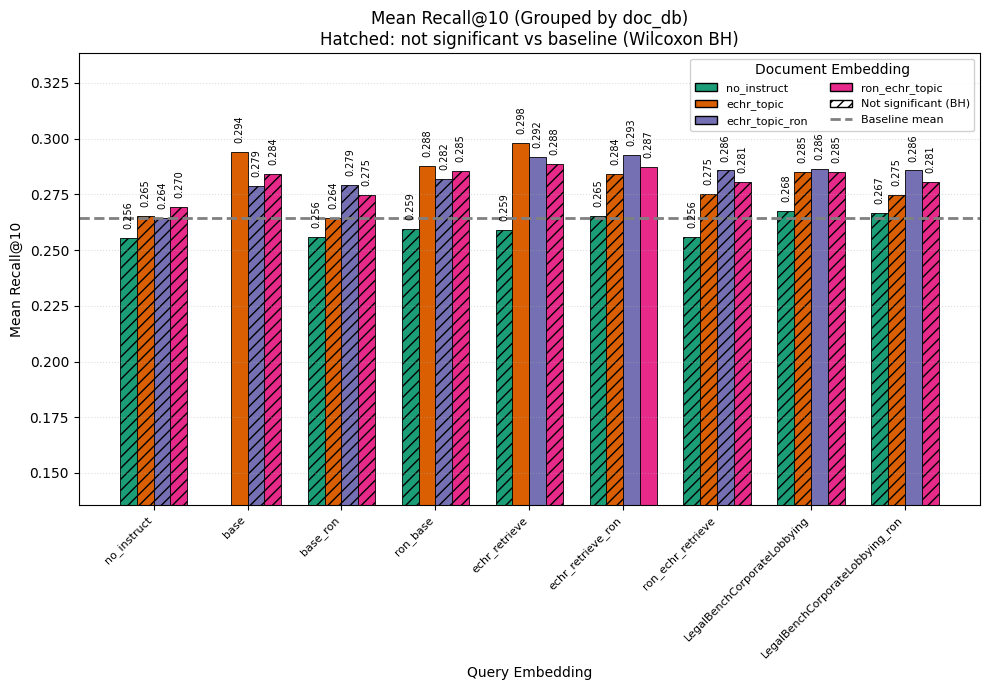

In [140]:
# Grouped bar chart: mean_recall@10 per query_embedding (x) with 4 doc_db bars (distinct colors)
# Uses Wilcoxon baseline significance from cell 9 (significant_bh); hatched if NOT significant.
import math
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Source data: baseline Wilcoxon results
if 'wilcoxon_baseline_no_trans_df' in globals() and isinstance(wilcoxon_baseline_no_trans_df, pd.DataFrame) and not wilcoxon_baseline_no_trans_df.empty:
    source_df = wilcoxon_baseline_no_trans_df.copy()
else:
    raise RuntimeError("Wilcoxon baseline results not found. Run the 'Wilcoxon signed-rank tests vs baseline' cell first.")

# Ensure significance flag exists (prefer BH-corrected)
if 'significant_bh' not in source_df.columns:
    source_df['significant_bh'] = source_df['p_value'] < 0.05

plot_df = source_df.copy()

baseline_mean = float(source_df['baseline_mean_recall@10'].iloc[0])
print(f"Baseline mean: {baseline_mean}")

# Base (non-translation) ordering template
base_non_translation_order = [
    'no_instruct',
    'base', 'base_ron', 'ron_base',
    'echr_retrieve', 'echr_retrieve_ron', 'ron_echr_retrieve',
    'LegalBenchCorporateLobbying', 'LegalBenchCorporateLobbying_ron'
]
existing_queries = list(plot_df['query_embedding'].unique())

# Collect additional (non-translation) queries not in the template
additional_non_translations = [q for q in existing_queries
                               if not q.startswith('translation_') and q not in base_non_translation_order]

# Build translation ordering by mirroring base order where present
translation_prefix = 'translation_'
translation_order = []
for base_name in base_non_translation_order:
    t_name = f"{translation_prefix}{base_name}"
    if t_name in existing_queries:
        translation_order.append(t_name)
# Append any extra translation_* embeddings not already added
extra_translations = [q for q in existing_queries if q.startswith(translation_prefix) and q not in translation_order]
translation_order.extend(extra_translations)

# Final query order: all non-translation (template + extras) then all translation_* variants
query_order = [q for q in base_non_translation_order if q in existing_queries]
query_order.extend(additional_non_translations)
query_order.extend(translation_order)

# doc_db ordering (keep first four primary)
doc_db_order = ['no_instruct', 'echr_topic', 'echr_topic_ron', 'ron_echr_topic']
existing_doc = list(plot_df['doc_db'].unique())
for d in existing_doc:
    if d not in doc_db_order:
        doc_db_order.append(d)

# Colors
doc_colors = {
    'no_instruct': '#1b9e77',   # green
    'echr_topic': '#d95f02',    # orange
    'echr_topic_ron': '#7570b3',# purple
    'ron_echr_topic': '#e7298a' # pink/magenta
}
fallback_palette = ['#66a61e', '#e6ab02', '#a6761d', '#666666']

# Prepare figure
bar_positions = range(len(query_order))
bar_width = 0.18
fig, ax = plt.subplots(figsize=(max(10, 0.7 * len(query_order)), 7))

for idx_doc, doc_db in enumerate(doc_db_order[:4]):  # only first four requested
    offsets = [p + (idx_doc - 1.5) * bar_width for p in bar_positions]
    for q, x in zip(query_order, offsets):
        row = plot_df[(plot_df['query_embedding'] == q) & (plot_df['doc_db'] == doc_db)]
        if row.empty:
            continue
        val = float(row['mean_recall@10'].iloc[0])
        sig_bh = bool(row['significant_bh'].iloc[0])
        color = doc_colors.get(doc_db, fallback_palette[idx_doc % len(fallback_palette)])
        hatch = None if sig_bh else '///'  # crosshatch for non-significant (after BH)
        ax.bar(x, val, width=bar_width, color=color, edgecolor='black', linewidth=0.6, hatch=hatch)
        ax.text(x, val + 0.004, f"{val:.3f}", ha='center', va='bottom', fontsize=7, rotation=90)

# Baseline horizontal line
if baseline_mean is not None:
    ax.axhline(baseline_mean, color='gray', linestyle='--', linewidth=2, label='Baseline mean')

# X ticks centered under grouped bars
ax.set_xticks(list(bar_positions))
ax.set_xticklabels(query_order, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Mean Recall@10')
ax.set_xlabel('Query Embedding')
ax.set_title('Mean Recall@10 (Grouped by doc_db)\nHatched: not significant vs baseline (Wilcoxon BH)')

# Legend
legend_patches = []
for idx_doc, doc_db in enumerate(doc_db_order[:4]):
    legend_patches.append(Patch(facecolor=doc_colors.get(doc_db, fallback_palette[idx_doc % len(fallback_palette)]),
                                edgecolor='black', label=doc_db))
legend_patches.append(Patch(facecolor='white', edgecolor='black', hatch='///', label='Not significant (BH)'))
if baseline_mean is not None:
    legend_patches.append(Line2D([0],[0], color='gray', linestyle='--', linewidth=2, label='Baseline mean'))
ax.legend(handles=legend_patches, ncol=2, fontsize=8, framealpha=0.9, title='Document Embedding')

# Tight y-scale around data (retain 0 lower bound only if values near 0)
y_values_all = plot_df['mean_recall@10'].tolist()
if baseline_mean is not None:
    y_values_all.append(baseline_mean)
if y_values_all:
    y_min = min(y_values_all)
    y_max = max(y_values_all)
    margin = max(0.04, (y_max - y_min) * 0.05)
    lower = max(0.0, y_min - margin * 3)
    upper = min(1.0, y_max + margin)
    # Avoid zero span
    if upper - lower < 0.05:
        upper = min(1.0, lower + 0.05)
    ax.set_ylim(lower, upper)

ax.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

In [105]:
# Paired t-tests for a chosen embedding vs its Romanian variants
# Compares: embedding vs embedding_ron  and embedding vs ron_embedding_ron
from scipy.stats import ttest_rel
import pandas as pd

embedding = 'echr_retrieve'  # change if you want to test another root embedding
base_name = embedding
variant_suffix = f"{embedding}_ron"
variant_ronwrap = f"ron_{embedding}_ron"

if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data loading cell first.")

# Ensure recall@10 already computed
if 'recall@10' not in df.columns:
    raise RuntimeError("Column 'recall@10' not found. Run earlier recall computation cell.")

# Helper to run paired comparison merging on question_id + doc_db (ensures same retrieval context)
def paired_compare(query_a: str, query_b: str):
    subset_a = df[df['query_embedding'] == query_a][['question_id', 'doc_db', 'recall@10']].rename(columns={'recall@10': 'recall_a'})
    subset_b = df[df['query_embedding'] == query_b][['question_id', 'doc_db', 'recall@10']].rename(columns={'recall@10': 'recall_b'})
    if subset_a.empty or subset_b.empty:
        return None, f"One of the embeddings missing: {query_a if subset_a.empty else ''} {query_b if subset_b.empty else ''}".strip()
    merged = pd.merge(subset_a, subset_b, on=['question_id', 'doc_db'], how='inner').dropna()
    if merged.empty:
        return None, f"No overlapping (question_id, doc_db) pairs for {query_a} vs {query_b}."
    if len(merged) < 2:
        return None, f"Not enough pairs (n={len(merged)}) for a paired t-test: {query_a} vs {query_b}."
    stat, p_value = ttest_rel(merged['recall_a'], merged['recall_b'])
    result = {
        'embedding_A': query_a,
        'embedding_B': query_b,
        'mean_A': merged['recall_a'].mean(),
        'mean_B': merged['recall_b'].mean(),
        'n_pairs': len(merged),
        'statistic': stat,
        'p_value': p_value,
        'cohens_d_paired': ( (merged['recall_b'] - merged['recall_a']).mean() / (merged['recall_b'] - merged['recall_a']).std(ddof=1) ) if (merged['recall_b'] - merged['recall_a']).std(ddof=1) != 0 else float('inf')
    }
    return result, None

comparisons = [
    (base_name, variant_suffix),
    (base_name, variant_ronwrap)
]

for a, b in comparisons:
    res, err = paired_compare(a, b)
    title = f"Overall Comparison of query Embeddings ({a} vs {b})"
    print(title)
    print('-' * len(title))
    if err:
        print(f"Skipping: {err}\n")
        continue
    print(f"Mean Recall@10 ({a}): {res['mean_A']:.4f}")
    print(f"Mean Recall@10 ({b}): {res['mean_B']:.4f}")
    print(f"Number of Paired Samples: {res['n_pairs']}")
    print(f"Paired t-test statistic: {res['statistic']:.4f}")
    print(f"P-value: {res['p_value']:.6f}")
    print(f"Cohen's d (paired): {res['cohens_d_paired']:.4f}\n")

# Optional: aggregate results DataFrame
all_results = []
for a, b in comparisons:
    res, err = paired_compare(a, b)
    if res:
        all_results.append(res)
if all_results:
    summary_df = pd.DataFrame(all_results)
    print("Summary table:")
    print(summary_df[['embedding_A','embedding_B','mean_A','mean_B','n_pairs','statistic','p_value','cohens_d_paired']].to_markdown(index=False))
else:
    print("No successful paired comparisons.")

Overall Comparison of query Embeddings (echr_retrieve vs echr_retrieve_ron)
---------------------------------------------------------------------------
Mean Recall@10 (echr_retrieve): 0.2844
Mean Recall@10 (echr_retrieve_ron): 0.2823
Number of Paired Samples: 1812
Paired t-test statistic: 0.8046
P-value: 0.421143
Cohen's d (paired): -0.0189

Overall Comparison of query Embeddings (echr_retrieve vs ron_echr_retrieve_ron)
-------------------------------------------------------------------------------
Skipping: One of the embeddings missing:  ron_echr_retrieve_ron

Summary table:
| embedding_A   | embedding_B       |   mean_A |   mean_B |   n_pairs |   statistic |   p_value |   cohens_d_paired |
|:--------------|:------------------|---------:|---------:|----------:|------------:|----------:|------------------:|
| echr_retrieve | echr_retrieve_ron | 0.284416 | 0.282314 |      1812 |    0.804622 |  0.421143 |        -0.0189022 |


In [141]:
# Paired t-tests for a chosen doc_db embedding vs its Romanian variants
# Compares: doc_db vs doc_db_ron  and doc_db vs ron_doc_db
from scipy.stats import ttest_rel
import pandas as pd

doc_db_core = 'echr_topic'  # change if you want another document embedding root
base_doc = doc_db_core
variant_suffix = f"{doc_db_core}_ron"
variant_ronwrap = f"ron_{doc_db_core}"

if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data loading cell first.")
if 'recall@10' not in df.columns:
    raise RuntimeError("Column 'recall@10' not found. Run earlier recall computation cell.")

# Helper: align on question_id + query_embedding so only retrieval questions with both doc_db variants are compared
def paired_docdb_compare(doc_a: str, doc_b: str):
    subset_a = df[df['doc_db'] == doc_a][['question_id', 'query_embedding', 'recall@10']].rename(columns={'recall@10': 'recall_a'})
    subset_b = df[df['doc_db'] == doc_b][['question_id', 'query_embedding', 'recall@10']].rename(columns={'recall@10': 'recall_b'})
    if subset_a.empty or subset_b.empty:
        return None, f"One of the doc_db embeddings missing: {doc_a if subset_a.empty else ''} {doc_b if subset_b.empty else ''}".strip()
    merged = pd.merge(subset_a, subset_b, on=['question_id','query_embedding'], how='inner').dropna()
    if merged.empty:
        return None, f"No overlapping (question_id, query_embedding) pairs for {doc_a} vs {doc_b}."
    if len(merged) < 2:
        return None, f"Not enough pairs (n={len(merged)}) for a paired t-test: {doc_a} vs {doc_b}."
    stat, p_value = ttest_rel(merged['recall_a'], merged['recall_b'])
    result = {
        'doc_db_A': doc_a,
        'doc_db_B': doc_b,
        'mean_A': merged['recall_a'].mean(),
        'mean_B': merged['recall_b'].mean(),
        'n_pairs': len(merged),
        'statistic': stat,
        'p_value': p_value,
        'cohens_d_paired': ( (merged['recall_b'] - merged['recall_a']).mean() / (merged['recall_b'] - merged['recall_a']).std(ddof=1) ) if (merged['recall_b'] - merged['recall_a']).std(ddof=1) != 0 else float('inf')
    }
    return result, None

comparisons_doc = [
    (base_doc, variant_suffix),
    (base_doc, variant_ronwrap)
]

for a, b in comparisons_doc:
    res, err = paired_docdb_compare(a, b)
    title = f"Overall Comparison of doc_db Embeddings ({a} vs {b})"
    print(title)
    print('-' * len(title))
    if err:
        print(f"Skipping: {err}\n")
        continue
    print(f"Mean Recall@10 ({a}): {res['mean_A']:.4f}")
    print(f"Mean Recall@10 ({b}): {res['mean_B']:.4f}")
    print(f"Number of Paired Samples: {res['n_pairs']}")
    print(f"Paired t-test statistic: {res['statistic']:.4f}")
    print(f"P-value: {res['p_value']:.6f}")
    print(f"Cohen's d (paired): {res['cohens_d_paired']:.4f}\n")

# Optional summary table
all_doc_results = []
for a, b in comparisons_doc:
    res, err = paired_docdb_compare(a, b)
    if res:
        all_doc_results.append(res)
if all_doc_results:
    summary_doc_df = pd.DataFrame(all_doc_results)
    print("Summary table (doc_db comparisons):")
    print(summary_doc_df[['doc_db_A','doc_db_B','mean_A','mean_B','n_pairs','statistic','p_value','cohens_d_paired']].to_markdown(index=False))
else:
    print("No successful doc_db paired comparisons.")

Overall Comparison of doc_db Embeddings (echr_topic vs echr_topic_ron)
----------------------------------------------------------------------
Mean Recall@10 (echr_topic): 0.2926
Mean Recall@10 (echr_topic_ron): 0.2910
Number of Paired Samples: 8154
Paired t-test statistic: 0.9182
P-value: 0.358564
Cohen's d (paired): -0.0102

Overall Comparison of doc_db Embeddings (echr_topic vs ron_echr_topic)
----------------------------------------------------------------------
Mean Recall@10 (echr_topic): 0.2926
Mean Recall@10 (ron_echr_topic): 0.2921
Number of Paired Samples: 8154
Paired t-test statistic: 0.2865
P-value: 0.774487
Cohen's d (paired): -0.0032

Summary table (doc_db comparisons):
| doc_db_A   | doc_db_B       |   mean_A |   mean_B |   n_pairs |   statistic |   p_value |   cohens_d_paired |
|:-----------|:---------------|---------:|---------:|----------:|------------:|----------:|------------------:|
| echr_topic | echr_topic_ron | 0.292571 | 0.290965 |      8154 |    0.918157 |  0.3

In [142]:
# Wilcoxon signed-rank tests vs translation baseline only, with Benjamini–Hochberg correction
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Preconditions
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data loading cell first.")
if 'recall@10' not in df.columns:
    raise RuntimeError("Column 'recall@10' not found. Compute it before running this cell.")
if 'baseline_doc_db' not in globals() or 'baseline_query' not in globals():
    raise RuntimeError("Baseline variables not set. Define 'baseline_doc_db' and 'baseline_query' first.")

# Keep only rows whose query_embedding contains 'translation'
tw_df = df[df['query_embedding'].str.contains('translation', na=False)].copy()
if tw_df.empty:
    raise ValueError("No rows with 'translation' in query_embedding were found.")

# Define translation baseline (mirror earlier convention)
translation_baseline_query = f"translation_{baseline_query}"
base_mask_t = (tw_df['doc_db'] == baseline_doc_db) & (tw_df['query_embedding'] == translation_baseline_query)
base_subset_t = tw_df.loc[base_mask_t, ['question_id', 'recall@10']].rename(columns={'recall@10': 'recall_baseline'})
if base_subset_t.empty:
    raise ValueError(
        f"No translation baseline rows for doc_db='{baseline_doc_db}', query_embedding='{translation_baseline_query}'."
    )

baseline_translation_mean = float(base_subset_t['recall_baseline'].mean())

# Run Wilcoxon vs translation baseline for each (doc_db, query_embedding)
w_rows_t = []
for (doc_db, query_embedding), group in tw_df.groupby(['doc_db', 'query_embedding']):
    # Skip baseline itself
    if doc_db == baseline_doc_db and query_embedding == translation_baseline_query:
        continue

    grp = group[['question_id', 'recall@10']].rename(columns={'recall@10': 'recall_group'})
    merged = base_subset_t.merge(grp, on='question_id', how='inner').dropna()

    # Need enough paired samples; Wilcoxon also needs some non-zero diffs
    if len(merged) < 5:
        continue

    try:
        stat, p_value = wilcoxon(merged['recall_baseline'], merged['recall_group'], alternative='two-sided')
        diffs = merged['recall_group'].to_numpy() - merged['recall_baseline'].to_numpy()
        n_non_zero = int(np.sum(diffs != 0))
        if n_non_zero > 0:
            # Approximate Z-score for effect size r
            z_score = (stat - n_non_zero * (n_non_zero + 1) / 4) / np.sqrt(
                n_non_zero * (n_non_zero + 1) * (2 * n_non_zero + 1) / 24
            )
            effect_size_r = z_score / np.sqrt(n_non_zero)
        else:
            effect_size_r = 0.0

        w_rows_t.append({
            'doc_db': doc_db,
            'query_embedding': query_embedding,
            'mean_recall@10': float(grp['recall_group'].mean()),
            'baseline_mean_recall@10': baseline_translation_mean,
            'median_recall@10': float(grp['recall_group'].median()),
            'n_pairs': int(len(merged)),
            'wilcoxon_stat': float(stat),
            'p_value': float(p_value),
            'effect_size_r': float(effect_size_r),
            'mean_diff': float(merged['recall_group'].mean() - merged['recall_baseline'].mean())
        })
    except Exception:
        # Skip comparisons where Wilcoxon cannot be computed (e.g., all diffs zero)
        continue

translation_wilcoxon_baseline_df = pd.DataFrame(w_rows_t)

if not translation_wilcoxon_baseline_df.empty:
    rejected_t, p_adj_t, _, _ = multipletests(
        translation_wilcoxon_baseline_df['p_value'].values, method='fdr_bh', alpha=0.05
    )
    translation_wilcoxon_baseline_df['p_adjusted_bh'] = p_adj_t
    translation_wilcoxon_baseline_df['significant_bh'] = rejected_t
    translation_wilcoxon_baseline_df = translation_wilcoxon_baseline_df.sort_values('p_value', ascending=True)

    print(f"Total translation comparisons vs baseline: {len(translation_wilcoxon_baseline_df)}")
    print(f"Significant after BH correction (α=0.05): {int(translation_wilcoxon_baseline_df['significant_bh'].sum())}")
    print(f"Mean raw p-value: {translation_wilcoxon_baseline_df['p_value'].mean():.4f}")
    print(f"Median raw p-value: {translation_wilcoxon_baseline_df['p_value'].median():.4f}")

    display_cols_t = [
        'doc_db', 'query_embedding', 'mean_diff', 'p_value', 'p_adjusted_bh', 'significant_bh',
        'effect_size_r', 'n_pairs', 'mean_recall@10', 'baseline_mean_recall@10'
    ]
    print("\nTop 20 most significant translation vs baseline (by p-value):")
    print(translation_wilcoxon_baseline_df[display_cols_t].head(20).to_markdown(index=False))
else:
    print("No valid translation Wilcoxon comparisons vs baseline could be performed.")

# Expose the DataFrame for downstream use
translation_wilcoxon_baseline_df

Total translation comparisons vs baseline: 35
Significant after BH correction (α=0.05): 28
Mean raw p-value: 0.0696
Median raw p-value: 0.0009

Top 20 most significant translation vs baseline (by p-value):
| doc_db         | query_embedding                             |   mean_diff |     p_value |   p_adjusted_bh | significant_bh   |   effect_size_r |   n_pairs |   mean_recall@10 |   baseline_mean_recall@10 |
|:---------------|:--------------------------------------------|------------:|------------:|----------------:|:-----------------|----------------:|----------:|-----------------:|--------------------------:|
| ron_echr_topic | translation_echr_retrieve_ron               |   0.0437919 | 3.11218e-07 |     1.08926e-05 | True             |       -0.368988 |       453 |         0.311344 |                  0.267552 |
| echr_topic     | translation_ron_base                        |   0.0420117 | 1.3262e-06  |     2.32084e-05 | True             |       -0.353423 |       453 |         0.309

,doc_db,query_embedding,mean_recall@10,baseline_mean_recall@10,median_recall@10,n_pairs,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
31,ron_echr_topic,translation_echr_retrieve_ron,0.311344,0.267552,0.250000,453,5322.0,3.112184e-07,-0.368988,0.043792,0.000011,True
7,echr_topic,translation_ron_base,0.309563,0.267552,0.250000,453,5207.0,1.326196e-06,-0.353423,0.042012,0.000023,True
34,ron_echr_topic,translation_ron_echr_retrieve,0.310058,0.267552,0.250000,453,5295.0,2.385100e-06,-0.344741,0.042506,0.000025,True
30,ron_echr_topic,translation_echr_retrieve,0.311639,0.267552,0.250000,453,5325.0,2.897569e-06,-0.341781,0.044087,0.000025,True
8,echr_topic,translation_ron_echr_retrieve,0.314120,0.267552,0.250000,453,5679.0,5.033455e-06,-0.330007,0.046569,0.000035,True
4,echr_topic,translation_echr_retrieve,0.313299,0.267552,0.250000,453,6666.5,7.075845e-06,-0.314199,0.045747,0.000041,True
16,echr_topic_ron,translation_ron_base,0.306644,0.267552,0.250000,453,5170.0,9.097914e-06,-0.328752,0.039093,0.000045,True
14,echr_topic_ron,translation_echr_retrieve_ron,0.306687,0.267552,0.250000,453,5140.5,1.143001e-05,-0.325911,0.039135,0.000050,True
2,echr_topic,translation_base,0.305298,0.267552,0.250000,453,4884.5,2.696747e-05,-0.317112,0.037746,0.000105,True
0,echr_topic,translation_LegalBenchCorporateLobbying,0.305835,0.267552,0.250000,453,5109.0,7.469009e-05,-0.298326,0.038283,0.000261,True


In [146]:
# Wilcoxon signed-rank test with Benjamini–Hochberg correction for all pairwise comparisons (translation-only)
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Preconditions
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data loading cell first.")
if 'recall@10' not in df.columns:
    raise RuntimeError("Column 'recall@10' not found. Compute it before running this cell.")

# Filter to translation-only query embeddings
wt_df = df[df['query_embedding'].str.contains('translation', na=False)].copy()
if wt_df.empty:
    raise ValueError("No rows with 'translation' in query_embedding were found.")

# Create all unique (doc_db, query_embedding) combinations
unique_configs_t = wt_df[['doc_db', 'query_embedding']].drop_duplicates()
config_list_t = [(row['doc_db'], row['query_embedding']) for _, row in unique_configs_t.iterrows()]

# Generate all pairwise combinations
pairwise_comparisons_t = list(combinations(config_list_t, 2))

# Run Wilcoxon signed-rank test for each pair
wilcoxon_results_t = []
for (doc_db1, query_emb1), (doc_db2, query_emb2) in pairwise_comparisons_t:
    # Get scores for configuration 1 and 2, index by question_id for pairing
    config1_scores = wt_df[(wt_df['doc_db'] == doc_db1) & (wt_df['query_embedding'] == query_emb1)].set_index('question_id')['recall@10']
    config2_scores = wt_df[(wt_df['doc_db'] == doc_db2) & (wt_df['query_embedding'] == query_emb2)].set_index('question_id')['recall@10']

    # Paired by common question_ids
    common_ids = config1_scores.index.intersection(config2_scores.index)
    if len(common_ids) < 5:
        continue

    scores1_paired = config1_scores.loc[common_ids].values
    scores2_paired = config2_scores.loc[common_ids].values

    try:
        stat, p_value = wilcoxon(scores1_paired, scores2_paired, alternative='two-sided')

        differences = scores2_paired - scores1_paired
        n_non_zero = np.sum(differences != 0)
        if n_non_zero > 0:
            z_score = (stat - n_non_zero * (n_non_zero + 1) / 4) / np.sqrt(
                n_non_zero * (n_non_zero + 1) * (2 * n_non_zero + 1) / 24
            )
            effect_size_r = z_score / np.sqrt(n_non_zero)
        else:
            effect_size_r = 0

        wilcoxon_results_t.append({
            'A_doc_db': doc_db1,
            'A_query_embedding': query_emb1,
            'B_doc_db': doc_db2,
            'B_query_embedding': query_emb2,
            'mean_recall@10_A': scores1_paired.mean(),
            'mean_recall@10_B': scores2_paired.mean(),
            'median_recall@10_A': np.median(scores1_paired),
            'median_recall@10_B': np.median(scores2_paired),
            'n_pairs': int(len(common_ids)),
            'wilcoxon_stat': float(stat),
            'p_value': float(p_value),
            'effect_size_r': float(effect_size_r),
            'mean_diff': float(scores2_paired.mean() - scores1_paired.mean())
        })
    except Exception:
        continue

# Convert to DataFrame
translation_wilcoxon_df = pd.DataFrame(wilcoxon_results_t)

if not translation_wilcoxon_df.empty:
    p_values_t = translation_wilcoxon_df['p_value'].values
    rejected_t, p_adjusted_t, _, _ = multipletests(p_values_t, method='fdr_bh', alpha=0.05)

    translation_wilcoxon_df['p_adjusted_bh'] = p_adjusted_t
    translation_wilcoxon_df['significant_bh'] = rejected_t

    translation_wilcoxon_df = translation_wilcoxon_df.sort_values('p_value')

    print(f"Total translation pairwise comparisons: {len(translation_wilcoxon_df)}")
    print(f"Significant after BH correction (α=0.05): {translation_wilcoxon_df['significant_bh'].sum()}")
    print(f"Mean p-value: {translation_wilcoxon_df['p_value'].mean():.4f}")
    print(f"Median p-value: {translation_wilcoxon_df['p_value'].median():.4f}")

    display_cols_t = [
        'A_doc_db', 'A_query_embedding', 'B_doc_db', 'B_query_embedding',
        'mean_diff', 'p_value', 'p_adjusted_bh', 'significant_bh', 'effect_size_r', 'n_pairs'
    ]
    print("\nTop 20 most significant translation pairwise comparisons (sorted by p-value):")
    print(translation_wilcoxon_df[display_cols_t].head(20).to_markdown(index=False))

    significant_t_df = translation_wilcoxon_df[translation_wilcoxon_df['significant_bh']]
    print(f"\nAll {len(significant_t_df)} significant translation comparisons after BH correction:")
    if not significant_t_df.empty:
        print(significant_t_df[display_cols_t].to_markdown(index=False))
    else:
        print("No significant differences found after BH correction.")

translation_wilcoxon_df

Total translation pairwise comparisons: 630
Significant after BH correction (α=0.05): 189
Mean p-value: 0.2559
Median p-value: 0.1229

Top 20 most significant translation pairwise comparisons (sorted by p-value):
| A_doc_db       | A_query_embedding             | B_doc_db    | B_query_embedding             |   mean_diff |     p_value |   p_adjusted_bh | significant_bh   |   effect_size_r |   n_pairs |
|:---------------|:------------------------------|:------------|:------------------------------|------------:|------------:|----------------:|:-----------------|----------------:|----------:|
| ron_echr_topic | translation_echr_retrieve_ron | no_instruct | translation_echr_retrieve_ron |  -0.0447824 | 2.92275e-08 |     1.84134e-05 | True             |       -0.416583 |       453 |
| ron_echr_topic | translation_echr_retrieve     | no_instruct | translation_echr_retrieve_ron |  -0.0450778 | 2.37023e-07 |     6.22162e-05 | True             |       -0.379639 |       453 |
| ron_echr_topic | 

,A_doc_db,A_query_embedding,B_doc_db,B_query_embedding,mean_recall@10_A,mean_recall@10_B,median_recall@10_A,median_recall@10_B,n_pairs,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
385,ron_echr_topic,translation_echr_retrieve_ron,no_instruct,translation_echr_retrieve_ron,0.311344,0.266561,0.250000,0.176471,453,4093.0,2.922754e-08,-0.416583,-0.044782,0.000018,True
340,ron_echr_topic,translation_echr_retrieve,no_instruct,translation_echr_retrieve_ron,0.311639,0.266561,0.250000,0.176471,453,4836.5,2.370234e-07,-0.379639,-0.045078,0.000062,True
387,ron_echr_topic,translation_echr_retrieve_ron,no_instruct,translation_base,0.311344,0.267552,0.250000,0.200000,453,5322.0,3.112184e-07,-0.368988,-0.043792,0.000062,True
544,no_instruct,translation_echr_retrieve_ron,echr_topic,translation_ron_echr_retrieve,0.266561,0.314120,0.176471,0.250000,453,4128.5,4.095173e-07,-0.385956,0.047559,0.000062,True
545,no_instruct,translation_echr_retrieve_ron,echr_topic,translation_echr_retrieve,0.266561,0.313299,0.176471,0.250000,453,4750.0,4.937796e-07,-0.372495,0.046737,0.000062,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,ron_echr_topic,translation_LegalBenchCorporateLobbying,echr_topic,translation_LegalBenchCorporateLobbying,0.301238,0.305835,0.250000,0.250000,453,4314.0,9.834964e-01,-0.001806,0.004597,0.988231,False
483,no_instruct,translation_base_ron,no_instruct,translation_no_instruct,0.283314,0.284212,0.200000,0.200000,453,4648.5,9.835252e-01,-0.001769,0.000898,0.988231,False
50,echr_topic_ron,translation_ron_echr_retrieve,ron_echr_topic,translation_LegalBenchCorporateLobbying_ron,0.298065,0.301664,0.250000,0.250000,453,5505.0,9.877751e-01,-0.001259,0.003600,0.990921,False
530,no_instruct,translation_ron_base,echr_topic,translation_base_ron,0.283726,0.286312,0.200000,0.214286,453,8050.0,9.942502e-01,-0.000538,0.002586,0.995831,False


In [148]:
t_selection = translation_wilcoxon_df[(translation_wilcoxon_df['A_doc_db'] == 'echr_topic') & (translation_wilcoxon_df['B_doc_db'] == 'echr_topic')]
t_selection

,A_doc_db,A_query_embedding,B_doc_db,B_query_embedding,mean_recall@10_A,mean_recall@10_B,median_recall@10_A,median_recall@10_B,n_pairs,wilcoxon_stat,p_value,effect_size_r,mean_diff,p_adjusted_bh,significant_bh
596,echr_topic,translation_base_ron,echr_topic,translation_ron_base,0.286312,0.309563,0.214286,0.250000,453,1749.5,0.000252,-0.352015,0.023252,0.002525,True
594,echr_topic,translation_base_ron,echr_topic,translation_ron_echr_retrieve,0.286312,0.314120,0.214286,0.250000,453,3367.0,0.002385,-0.258440,0.027808,0.012215,True
595,echr_topic,translation_base_ron,echr_topic,translation_echr_retrieve,0.286312,0.313299,0.214286,0.250000,453,3744.0,0.003224,-0.245299,0.026987,0.015274,True
599,echr_topic,translation_base_ron,echr_topic,translation_base,0.286312,0.305298,0.214286,0.250000,453,1638.0,0.005237,-0.281890,0.018986,0.022291,True
619,echr_topic,translation_ron_base,echr_topic,translation_LegalBenchCorporateLobbying_ron,0.309563,0.296317,0.250000,0.222222,453,2583.0,0.008821,-0.239931,-0.013247,0.033477,True
598,echr_topic,translation_base_ron,echr_topic,translation_LegalBenchCorporateLobbying,0.286312,0.305835,0.214286,0.250000,453,3083.0,0.018201,-0.209457,0.019523,0.058207,False
608,echr_topic,translation_ron_echr_retrieve,echr_topic,translation_LegalBenchCorporateLobbying_ron,0.314120,0.296317,0.250000,0.222222,453,2858.5,0.022417,-0.206567,-0.017803,0.068224,False
597,echr_topic,translation_base_ron,echr_topic,translation_echr_retrieve_ron,0.286312,0.306908,0.214286,0.250000,453,3924.0,0.025922,-0.187446,0.020596,0.076314,False
614,echr_topic,translation_echr_retrieve,echr_topic,translation_LegalBenchCorporateLobbying_ron,0.313299,0.296317,0.250000,0.222222,453,4294.5,0.036297,-0.173161,-0.016982,0.096486,False
618,echr_topic,translation_ron_base,echr_topic,translation_no_instruct,0.309563,0.300164,0.250000,0.222222,453,2606.0,0.041812,-0.189714,-0.009399,0.108402,False


In [ ]:
# Translation-only comparison and grouped bar chart (analogous to cell 5)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

# 1. Filter to only translation_ query embeddings
translation_df = df[df['query_embedding'].str.startswith('translation_')].copy()
if translation_df.empty:
    raise RuntimeError("No query embeddings starting with 'translation_' found in df.")

# 2. Define translation baseline (reuse baseline_doc_db from earlier, but prefix baseline_query)
translation_baseline_query = f"translation_{baseline_query}"
print(f"Translation baseline -> doc_db='{baseline_doc_db}', query_embedding='{translation_baseline_query}'")

if translation_baseline_query not in translation_df['query_embedding'].unique():
    raise ValueError(f"Baseline translation query '{translation_baseline_query}' not present among translation query embeddings: {translation_df['query_embedding'].unique()}")

baseline_translation_scores = translation_df[(translation_df['doc_db'] == baseline_doc_db) &
                                             (translation_df['query_embedding'] == translation_baseline_query)]['recall@10']
if baseline_translation_scores.empty:
    raise ValueError("No baseline translation scores found (check doc_db / query embedding alignment).")

# 3. Paired t-tests vs translation baseline across (doc_db, query_embedding)
translation_results = []
for (doc_db, query_embedding), group in translation_df.groupby(['doc_db', 'query_embedding']):
    if doc_db == baseline_doc_db and query_embedding == translation_baseline_query:
        continue
    group_scores = group['recall@10']
    # Ensure paired by question id: align baseline and group on question_id
    base_subset = translation_df[(translation_df['doc_db'] == baseline_doc_db) &
                                 (translation_df['query_embedding'] == translation_baseline_query)]
    merged = pd.merge(base_subset[['question_id', 'recall@10']],
                      group[['question_id', 'recall@10']],
                      on='question_id', suffixes=('_baseline', '_group')).dropna()
    if merged.empty:
        # Skip groups without overlapping question_ids
        continue
    stat, p_value = ttest_rel(merged['recall@10_baseline'], merged['recall@10_group'])
    translation_results.append({
        'doc_db': doc_db,
        'query_embedding': query_embedding,
        'mean_recall@10': group_scores.mean(),
        'baseline_mean_recall@10': baseline_translation_scores.mean(),
        'p_value': p_value,
        'stat': stat,
        'n_pairs': len(merged)
    })

translation_results_df = pd.DataFrame(translation_results)
if translation_results_df.empty:
    raise RuntimeError("translation_results_df is empty – no comparable groups formed.")

translation_results_df.sort_values(by='stat', inplace=True, ascending=True)
print("Translation-only results (sorted by test statistic ascending):")
print(translation_results_df.to_markdown(index=False))



Using translation_wilcoxon_baseline_df (Wilcoxon vs translation baseline, BH-corrected) for plotting.


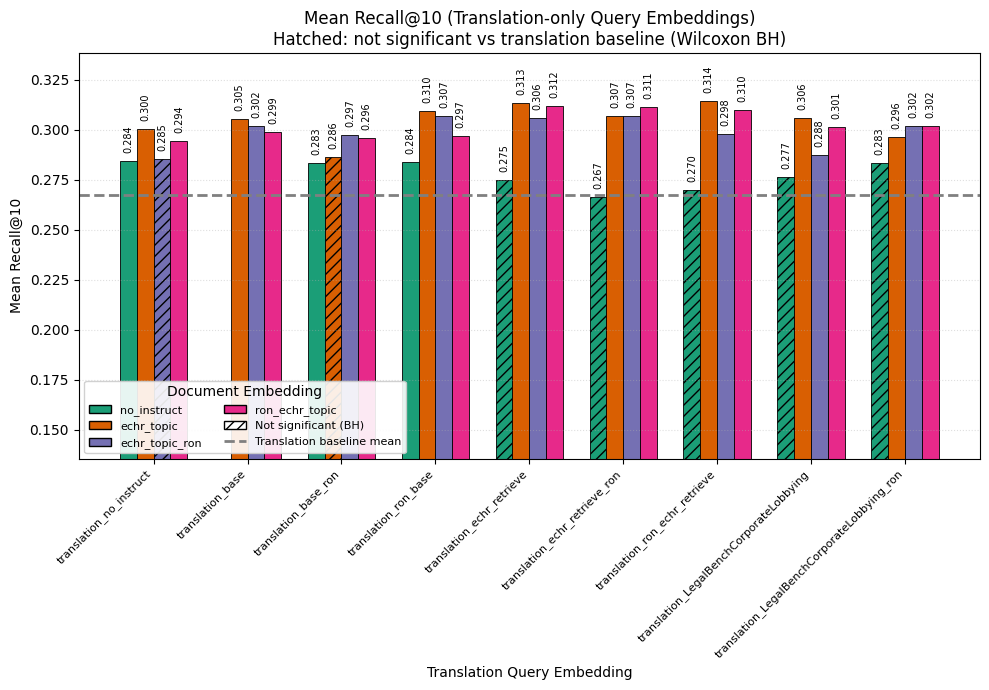

In [145]:
# Plot grouped bar chart for translation-only embeddings
# Uses Wilcoxon vs translation baseline significance (BH-corrected) for hatching
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Require translation_wilcoxon_baseline_df
if 'translation_wilcoxon_baseline_df' not in globals() or not isinstance(translation_wilcoxon_baseline_df, pd.DataFrame) or translation_wilcoxon_baseline_df.empty:
    raise RuntimeError("translation_wilcoxon_baseline_df not found or empty. Run the translation Wilcoxon-vs-baseline cell first.")

plot_df_t = translation_wilcoxon_baseline_df.copy()
print("Using translation_wilcoxon_baseline_df (Wilcoxon vs translation baseline, BH-corrected) for plotting.")

# Assume BH-corrected significance column exists
plot_df_t['significant'] = plot_df_t['significant_bh']

# Use baseline mean directly
translation_baseline_mean = float(plot_df_t['baseline_mean_recall@10'].iloc[0])

# Ensure mean value column exists
if 'mean_recall@10' not in plot_df_t.columns:
    raise RuntimeError("Expected 'mean_recall@10' column not found in translation_wilcoxon_baseline_df.")

# Establish query order based on base order mirrored with translation_ prefix
base_non_translation_order = [
    'no_instruct',
    'base', 'base_ron', 'ron_base',
    'echr_retrieve', 'echr_retrieve_ron', 'ron_echr_retrieve',
    'LegalBenchCorporateLobbying', 'LegalBenchCorporateLobbying_ron'
]
translation_prefix = 'translation_'
existing_translation_queries = list(plot_df_t['query_embedding'].unique())
translation_order = []
for base_name in base_non_translation_order:
    t_name = f"{translation_prefix}{base_name}"
    if t_name in existing_translation_queries:
        translation_order.append(t_name)
# Append any extra translation_* embeddings not in predefined order
extra_translation_queries = [q for q in existing_translation_queries if q not in translation_order]
translation_order.extend(extra_translation_queries)

# doc_db ordering (same first four primary + extras)
doc_db_order = ['no_instruct', 'echr_topic', 'echr_topic_ron', 'ron_echr_topic']
for d in plot_df_t['doc_db'].unique():
    if d not in doc_db_order:
        doc_db_order.append(d)

# Colors
doc_colors = {
    'no_instruct': '#1b9e77',
    'echr_topic': '#d95f02',
    'echr_topic_ron': '#7570b3',
    'ron_echr_topic': '#e7298a'
}
fallback_palette = ['#66a61e', '#e6ab02', '#a6761d', '#666666']

bar_positions = range(len(translation_order))
bar_width = 0.18
fig, ax = plt.subplots(figsize=(max(10, 0.7 * len(translation_order)), 7))

for idx_doc, doc_db in enumerate(doc_db_order[:4]):  # only first four requested
    offsets = [p + (idx_doc - 1.5) * bar_width for p in bar_positions]
    for q, x in zip(translation_order, offsets):
        row = plot_df_t[(plot_df_t['query_embedding'] == q) & (plot_df_t['doc_db'] == doc_db)]
        if row.empty:
            continue
        val = float(row['mean_recall@10'].iloc[0])
        sig_bh = bool(row['significant_bh'].iloc[0])
        color = doc_colors.get(doc_db, fallback_palette[idx_doc % len(fallback_palette)])
        hatch = None if sig_bh else '///'  # crosshatch for non-significant (after BH)
        ax.bar(x, val, width=bar_width, color=color, edgecolor='black', linewidth=0.6, hatch=hatch)
        ax.text(x, val + 0.004, f"{val:.3f}", ha='center', va='bottom', fontsize=7, rotation=90)

# Baseline horizontal line
ax.axhline(baseline_translation_mean, color='gray', linestyle='--', linewidth=2, label='Translation baseline mean')

# X axis
ax.set_xticks(list(bar_positions))
ax.set_xticklabels(translation_order, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Mean Recall@10')
ax.set_xlabel('Translation Query Embedding')
ax.set_title('Mean Recall@10 (Translation-only Query Embeddings)\nHatched: not significant vs translation baseline (Wilcoxon BH)')

# Legend
legend_patches = []
for idx_doc, doc_db in enumerate(doc_db_order[:4]):
    legend_patches.append(Patch(facecolor=doc_colors.get(doc_db, fallback_palette[idx_doc % len(fallback_palette)]),
                                edgecolor='black', label=doc_db))
legend_patches.append(Patch(facecolor='white', edgecolor='black', hatch='///', label='Not significant (BH)'))
legend_patches.append(Line2D([0],[0], color='gray', linestyle='--', linewidth=2, label='Translation baseline mean'))
ax.legend(handles=legend_patches, ncol=2, fontsize=8, framealpha=0.9, title='Document Embedding')

# Y-scale adjustment
y_vals_all = plot_df_t['mean_recall@10'].tolist() + [baseline_translation_mean]

# using y-scale from non english results for comparison:
ax.set_ylim(lower, upper)

ax.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()